In [23]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import matplotlib.pyplot as plt
import itertools
import math
import pandas as pd
import os
import numpy as np

In [25]:
BATCHSIZE = 64
EPOCH = 10
LATENT_DIM = 100
LATENT_DIM_DECODER = LATENT_DIM
SAMPLES = 10000
MAX_WORD_NUM = SAMPLES
MAX_SEQ_LEN = 100
EMBEDDING = MAX_SEQ_LEN

In [26]:
ner_df = pd.read_csv('/content/drive/My Drive/datasets/ner_dataset.csv', engine='python', na_values='NaN')

In [27]:
ner_df

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
...,...,...,...,...
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O


In [28]:
sentences_words = []
sentences_tags = []
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values: 
    if pd.notna(sent_num) and current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            current_sentence_words = []
            current_sentence_tags = []
    current_sentence_words.append(word)
    current_sentence_tags.append(tag)

In [29]:
vocab = set(itertools.chain.from_iterable(s for s in sentences_words)) 
tags = set(itertools.chain.from_iterable(s for s in sentences_tags))
sentenecs_lens = list(map(len, sentences_words))

In [30]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [31]:
words_tokenizer = Tokenizer(num_words=MAX_WORD_NUM)
words_tokenizer.fit_on_texts(sentences_words)
word_index = words_tokenizer.word_index
max_in_len = max(len(s) for s in sentences_words)
print(f"Number of input tokens: {len(word_index)}")
print(f"Maximum input sequence length: {max_in_len}")

Number of input tokens: 31811
Maximum input sequence length: 104


In [32]:
words_seq = words_tokenizer.texts_to_sequences(sentences_words)

In [33]:
words_seq_pad = pad_sequences(words_seq, maxlen=max_in_len)

In [34]:
tags_tokenizer = Tokenizer(num_words=MAX_WORD_NUM, filters='')
tags_tokenizer.fit_on_texts(sentences_tags)
tag_index = tags_tokenizer.word_index
max_out_len = max(len(s) for s in sentences_tags)
out_word_num = len(tag_index) + 1
print(f"Number of output tokens: {len(tag_index)}")
print("Maximum output sequence length: {}".format(max_out_len))

Number of output tokens: 17
Maximum output sequence length: 104


In [35]:
tags_seq = tags_tokenizer.texts_to_sequences(sentences_tags)

In [36]:
tags_seq_pad = pad_sequences(tags_seq, maxlen=max_out_len)

In [37]:
wordVec = {}
print('Loading wordVec')
with open('/content/drive/My Drive/datasets/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        data = line.split()
        word = data[0]
        vec = np.asarray(data[1:], dtype='float32')
        wordVec[word] = vec
print('Finished loading wordVec.')

Loading wordVec
Finished loading wordVec.


In [38]:
wordNum = min(MAX_WORD_NUM, len(word_index) + 1)
word_embedding = np.zeros((wordNum, EMBEDDING))

for tok, idx in word_index.items():
    if idx < MAX_WORD_NUM:
        word_vector = wordVec.get(tok)
        if word_vector is not None:
            word_embedding[idx] = word_vector

In [39]:
man_target_one_hot = np.zeros((len(sentences_words), max_out_len, out_word_num), dtype='float32')

for idx, tokVec in enumerate(tags_seq_pad):
    for tok_idx, tok in enumerate(tokVec):
        if (tok > 0):
            man_target_one_hot[idx, tok_idx, tok] = 1

In [40]:
from keras.layers import Embedding, Input, LSTM, GRU, Dense, Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda, TimeDistributed
import keras.backend as K
from keras.models import Model

In [41]:
embedding = Embedding(wordNum, EMBEDDING, weights=[word_embedding], input_length=max_in_len)

encoder_inputs = Input(shape=(max_in_len, ), dtype='int32',)
encoder_embedding = embedding(encoder_inputs)
encoder_LSTM = LSTM(LATENT_DIM, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

decoder_inputs = Input(shape=(max_out_len, ), dtype='int32',)
decoder_embedding = embedding(decoder_inputs)
decoder_LSTM = LSTM(LATENT_DIM_DECODER, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=[state_h, state_c])

outputs = TimeDistributed(Dense(18, activation='softmax'))(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], outputs)

In [42]:
def acc(y_train, pred):
    targ = K.argmax(y_train, axis=-1)
    pred = K.argmax(pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    mask = K.cast(K.greater(targ, 0), dtype='float32')
    correctCount = K.sum(mask * correct)
    totalCount = K.sum(mask)
    return correctCount / totalCount

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [43]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[acc, recall_m, precision_m, f1_m])
history = model.fit([words_seq_pad, tags_seq_pad],
               man_target_one_hot,
               batch_size=BATCHSIZE, 
               validation_split=0.3,
               epochs=EPOCH)


Epoch 1/10
525/525 [==============================] - 181s 335ms/step - loss: 0.0889 - acc: 0.9083 - recall_m: 0.8583 - precision_m: 0.5458 - f1_m: 0.5900 - val_loss: 0.0010 - val_acc: 0.9992 - val_recall_m: 0.9986 - val_precision_m: 0.2107 - val_f1_m: 0.3478
Epoch 2/10
525/525 [==============================] - 174s 331ms/step - loss: 7.6704e-04 - acc: 0.9996 - recall_m: 0.9988 - precision_m: 0.2106 - f1_m: 0.3477 - val_loss: 2.2396e-04 - val_acc: 0.9999 - val_recall_m: 0.9999 - val_precision_m: 0.2101 - val_f1_m: 0.3471
Epoch 3/10
525/525 [==============================] - 174s 332ms/step - loss: 1.7963e-04 - acc: 1.0000 - recall_m: 0.9999 - precision_m: 0.2103 - f1_m: 0.3475 - val_loss: 8.5454e-05 - val_acc: 1.0000 - val_recall_m: 1.0000 - val_precision_m: 0.2100 - val_f1_m: 0.3470
Epoch 4/10
525/525 [==============================] - 173s 329ms/step - loss: 7.5479e-05 - acc: 1.0000 - recall_m: 1.0000 - precision_m: 0.2107 - f1_m: 0.3480 - val_loss: 4.3663e-05 - val_acc: 1.0000 - va

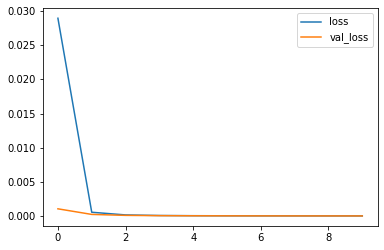

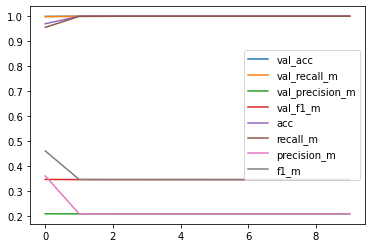

In [44]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['val_acc'], label='val_acc')
plt.plot(history.history['val_recall_m'], label='val_recall_m')
plt.plot(history.history['val_precision_m'], label='val_precision_m')
plt.plot(history.history['val_f1_m'], label='val_f1_m')
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['recall_m'], label='recall_m')
plt.plot(history.history['precision_m'], label='precision_m')
plt.plot(history.history['f1_m'], label='f1_m')
plt.legend()
plt.show()